### Project EDA

In [10]:
# col_names = [i.name for i in df.schema]

# for i in col_names:
#     count_of_nulls = df.select(df.ID.isNull()==True).count()
#     print(i,)

In [1]:
# Suppress Hadoop Info looging
!sed -i 's/hadoop.root.logger=INFO,console/hadoop.root.logger=WARN,console/' /usr/hadoop-3.3.2/etc/hadoop/log4j.properties

In [2]:
import pyspark
from pyspark.sql import SparkSession

conf = pyspark.SparkConf().setAll([('spark.master', 'local[*]'),
                                   ('spark.app.name', 'Basic Setup')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

2023-04-26 05:42:39,474 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [28]:
# Load dataframe

df = spark.read.csv("file:///home/work/Crimes_-_2001_to_Present.csv",header=True)

In [23]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Historical Wards 2003-2015: string (nullable = true)
 |-- Zip Codes: string (nullable = true)
 |-- Com

In [29]:
# Limit to data pre-2023

df = df.filter("Year < 2023")

In [6]:
# View primary crime types

#df.select('Primary Type').distinct().sort(df['Primary Type'].asc()).show(n=50,truncate=False)

ERROR:root:KeyboardInterrupt while sending command.                (4 + 4) / 16]
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.8/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [30]:
# Reclassify crime types
from pyspark.sql.functions import regexp_replace

new_cats = {'CRIM SEXUAL ASSAULT':'CRIMINAL SEXUAL ASSAULT','NON-CRIMINAL (SUBJECT SPECIFIED)':'NON-CRIMINAL', 'NON - CRIMINAL':'NON-CRIMINAL',
            'OTHER NARCOTIC VIOLATION':'NARCOTICS','PUBLIC INDECENCY':'PUBLIC INDECENCY/OBSCENITY', 'OBSCENITY':'PUBLIC INDECENCY/OBSCENITY'}

for i in new_cats:
    df = df.replace(i,new_cats[i],"Primary Type")

In [32]:
# Check number of primary types

df.select("Primary Type").distinct().count()

31

In [31]:
df.select('Primary Type').distinct().show(n=50,truncate=False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|OFFENSE INVOLVING CHILDREN       |
|CRIMINAL SEXUAL ASSAULT          |
|STALKING                         |
|PUBLIC PEACE VIOLATION           |
|ARSON                            |
|GAMBLING                         |
|CRIMINAL TRESPASS                |
|ASSAULT                          |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|THEFT                            |
|BATTERY                          |
|PUBLIC INDECENCY/OBSCENITY       |
|ROBBERY                          |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTIMIDATION                     |
|PROSTITUTION                     |
|DECEPTIVE PRACTICE               |
|CONCEALED CARRY LICENSE VIOLATION|
|SEX OFFENSE                      |
|CRIMINAL DAMAGE                  |
|NARCOTICS                        |
|NON-CRIMINAL                     |
|OTHER OFFENSE              

In [ ]:
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import col

df_type_counts = df.groupBy("Primary Type") \
  .agg(countDistinct('Description').alias("Count of Secondary Types")) \
  .orderBy(col("Count of Secondary Types").desc()) \

df_type_counts_pd = df_type_counts.toPandas()

<Axes: title={'center': 'Number of Secondary Types per Primary Type'}, xlabel='Primary Type', ylabel='Count'>

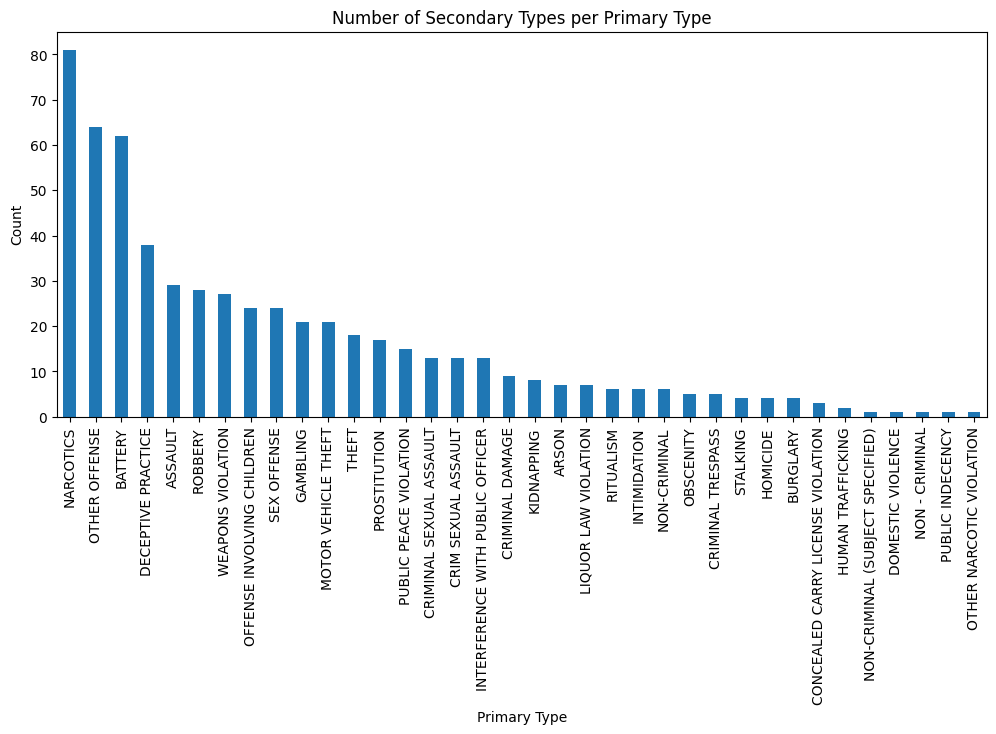

In [84]:
import matplotlib.pyplot as plt 

df_type_counts_pd.plot(kind='bar',x='Primary Type',y='Count of Secondary Types',figsize=(12,5),title="Number of Secondary Types per Primary Type",ylabel="Count",legend=False)

In [80]:
df.agg(countDistinct('Description')).show()

+------------------+
|count(Description)|
+------------------+
|               544|
+------------------+

